In [1]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import functools
import jax
import os
import pandas as pd
import mlflow
import pickle
import spot

from datetime import datetime
from jax import numpy as jnp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output
import mediapy

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import achql.stl
import achql.stl.expression_jax2 as stl

# tasks
from achql.brax.tasks import get_task
from achql.brax.utils import (
    make_cmdp,
    make_shaped_reward_mdp,
    make_shaped_reward_mdp2,
    make_reward_machine_mdp,
    make_aut_goal_mdp,
    make_aut_goal_cmdp
)

mlflow.set_tracking_uri(f"file:///home/tassos/.local/share/mlflow")
# mlflow.set_experiment("proj2-final-comparison")
mlflow.set_experiment("proj2-ur5e")

2025-01-12 19:58:35.327101: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


<Experiment: artifact_location='file:///home/tassos/.local/share/mlflow/546725870351684749', creation_time=1736532055797, experiment_id='546725870351684749', last_update_time=1736532055797, lifecycle_stage='active', name='proj2-ur5e', tags={}>

# Defining Env/Task

In [3]:

task = get_task("ur5e", "scalability_test")

env = task.env

spec = task.lo_spec
spec_tag = type(task).__name__
env_tag = type(env).__name__

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [4]:
options = task.get_options()

up [0. 0. 1.]
forward [0. 1. 0.]
right [1. 0. 0.]
left [-1.  0.  0.]
backward [ 0. -1.  0.]
down [ 0.  0. -1.]


# Visualizing Policy

## Loading from a previous run

In [5]:
from achql.brax.agents.hdcqn_automaton_her import networks as hdcq_aut_networks
from brax.training.acme import running_statistics

In [6]:
training_run_id = "449b832fb5df4b7d9740c22ed27ed671"
logged_model_path = f'runs:/{training_run_id}/policy_params'
real_path = mlflow.artifacts.download_artifacts(logged_model_path)
params = model.load_params(real_path)

In [7]:
run = mlflow.get_run(run_id=training_run_id)
if run.data.params["normalize_observations"] == "True":
    normalize_fn = running_statistics.normalize
    cost_normalize_fn = running_statistics.normalize
else:
    normalize_fn = lambda x, y: x
    cost_normalize_fn = lambda x, y: x

In [8]:
aut_goal_cmdp = make_aut_goal_cmdp(task, margin=0.0, randomize_goals=False)
hdcq_aut_network = hdcq_aut_networks.make_hdcq_networks(
      aut_goal_cmdp.observation_size,
      aut_goal_cmdp.cost_observation_size,
      aut_goal_cmdp.automaton.n_states,
      aut_goal_cmdp.action_size,
      # aut_goal_cmdp.n_unique_safety_conds,
      # aut_goal_cmdp,
      options=options,
      preprocess_observations_fn=normalize_fn,
      preprocess_cost_observations_fn=cost_normalize_fn,
)
make_option_policy = hdcq_aut_networks.make_option_inference_fn(hdcq_aut_network, aut_goal_cmdp, task.hdcqn_her_hps["safety_minimum"])
make_policy = hdcq_aut_networks.make_inference_fn(hdcq_aut_network, aut_goal_cmdp, task.hdcqn_her_hps["safety_minimum"])

In [9]:
inference_fn = make_policy(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

In [10]:
from achql.visualization.hierarchy import get_rollout

rollout, opt_traj, action = get_rollout(aut_goal_cmdp, jit_inference_fn, options, n_steps=300, seed=3, render_every=1)

In [11]:
mediapy.show_video(
# mediapy.write_video('./ant-maze-3d-rollout.mp4',
    env.render(
        [s.pipeline_state for s in rollout],
        camera='overview'
    ), fps=1.0 / env.dt
)

In [19]:
os.getcwd()

'/home/tassos/phd/research/second-project/task-aware-skill-composition/achql/demo'

## TEST

In [ ]:
HTML(html.render(env.sys, [state.pipeline_state for state in rollout]))

In [20]:
obs_traj = jnp.stack([state.obs for state in rollout])
position_traj = jnp.stack([state.obs[:2] for state in rollout])
reward_traj = jnp.stack([state.reward for state in rollout])

In [21]:
jax.numpy.save("obs_traj.npy", obs_traj)
jax.numpy.save("opt_traj.npy", opt_traj)

In [16]:
cost_traj = jnp.stack([state.info["cost"] for state in rollout])

In [18]:
(cost_traj < 0).any()

Array(False, dtype=bool)

# Visualizing 3D HDCQN Q Functions

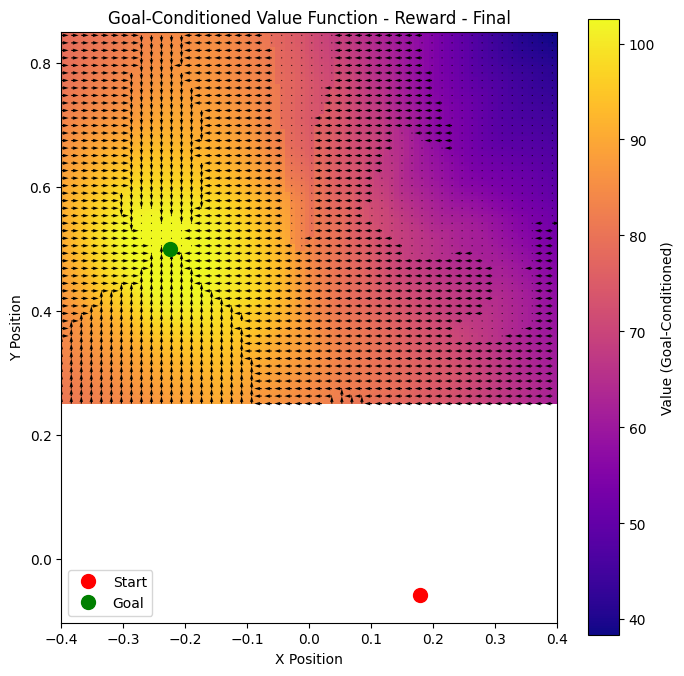

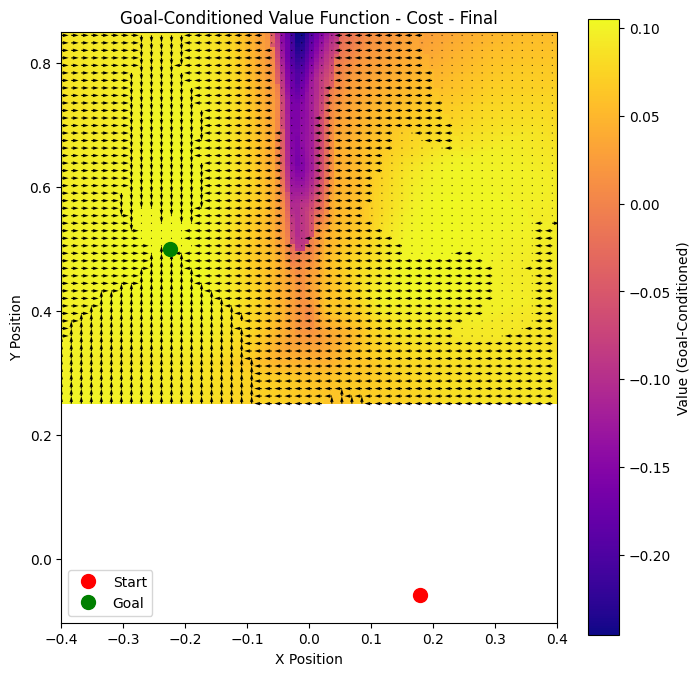

In [70]:
from achql.visualization.critic import make_plots_for_3d_hdcqn_aut

plot1, plot2 = make_plots_for_3d_hdcqn_aut(
        aut_goal_cmdp,
        make_option_policy,
        # make_test_policy,
        hdcq_aut_network,
        params,
        "Final",
        tmp_state_fn=lambda x: x.replace(obs=x.obs.at[2].set(0.5).at[6:9].set(jnp.array([-0.225, 0.5, 0.5]))),
        save_and_close=False,
        seed=0,
        grid_size=100,
        x_min = -0.4,
        x_max = 0.4,
        y_min = 0.25,
        y_max = 0.85,
)

# Visualizing HDCQN Q Functions

In [48]:
def make_test_option_policy(unused, **kwargs):
    def test_option_policy(unused, unused2):
        return jnp.ones((unused.shape[0], ), dtype=jnp.int32) * 2, {}
    return test_option_policy

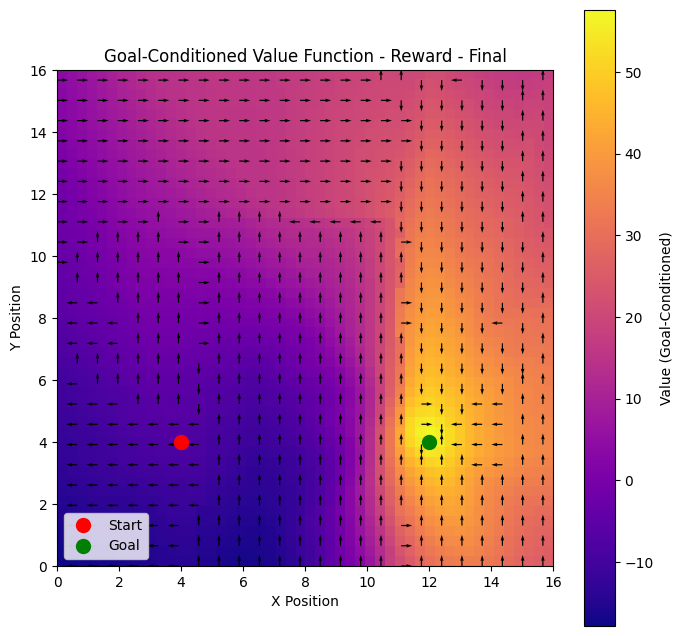

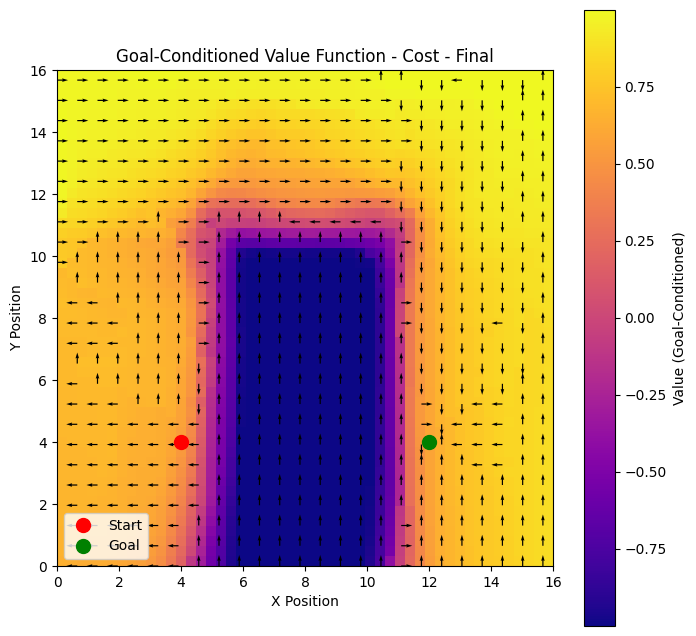

In [20]:
from achql.brax.agents.hdcqn_automaton_her import networks as hdcq_networks
from achql.visualization.critic import make_plots_for_hdcqn_aut

plot1, plot2 = make_plots_for_hdcqn_aut(
        aut_goal_cmdp,
        make_option_policy,
        # make_test_policy,
        hdcq_aut_network,
        params,
        "Final",
        # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:].set(jnp.array([4., 12., 0., 0., 1.]))),
        save_and_close=False,
        seed=0,
        grid_size=50,
)

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Goal-Conditioned Value Function - Reward - Final'}, xlabel='X Position', ylabel='Y Position'>)

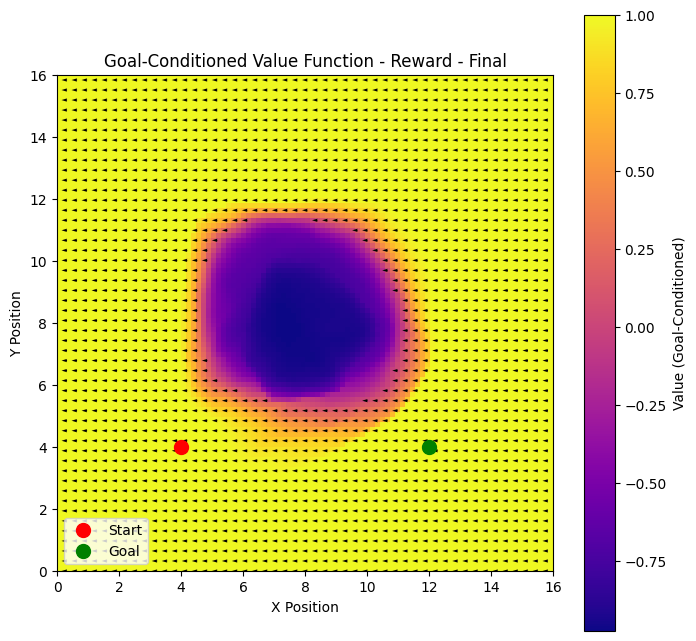

In [49]:
from achql.visualization.critic import make_plots_for_forbidden_actions

make_plots_for_forbidden_actions(
        aut_goal_cmdp,
        task.hdcqn_her_hps["safety_minimum"],
        make_test_option_policy,
        hdcq_aut_network,
        params,
        "Final",
        # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:6].set(jnp.array([12., 12.]))),
        save_and_close=False,
)   

In [ ]:
from achql.brax.agents.hdcqn_automaton_her import networks as hdcqn_automaton_her
from achql.visualization.critic import make_plots_for_hdcqn
from brax.training.acme import running_statistics

tmp_env = make_aut_goal_cmdp(task)
seed=0

# normalize = lambda x, y: x
normalize = running_statistics.normalize

hdcq_network = hdcqn_automaton_her.make_hdcq_networks(
      env.observation_size,
      env.goalless_observation_size,
      env.action_size,
      options=options,
      preprocess_observations_fn=normalize,
)
make_policy = hdcq_networks.make_option_inference_fn(hdcq_network, task.hdcqn_her_hps["cost_budget"])

plot1, plot2 = make_plots_for_hdcqn(
        tmp_env,
        make_policy,
        hdcq_network,
        params,
        0,
)

# Visualizing HDQN Q Function

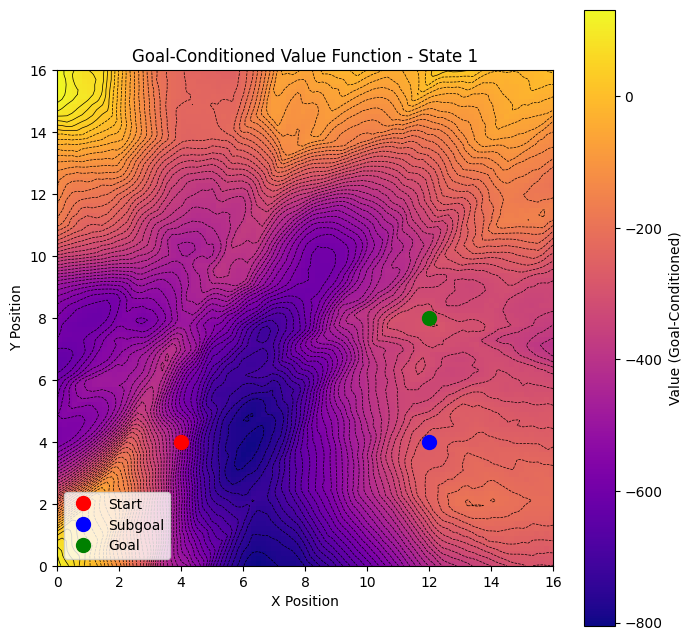

In [64]:
from achql.brax.agents.hdqn import networks as hdq_networks
from achql.visualization.critic import make_plots_for_hdqn
from achql.brax.training.acme import running_statistics

# normalize = lambda x, y: x
# normalize = running_statistics.normalize
# normalize = functools.partial(running_statistics.normalize, mask=normalization_mask)

tmp_env = make_aut_goal_mdp(task)
seed=0

plot1 = make_plots_for_hdqn(
        tmp_env,
        hdq_aut_network,
        params,
        "State 1",
        seed=seed,
        tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:6].set(jnp.array([12., 8.]))),
        save_and_close=False,
)

# state_zero_suffix = jnp.concatenate((jnp.array([4.0, 12.0]), tmp_env.automaton.one_hot_encode(jnp.int32(1))))
# state_zero_suffix = jnp.array([4.0, 12.0])

# plot2 = make_plots_for_hdqn(
#         tmp_env,
#         hdq_aut_network,
#         params,
#         "State 0",
#         seed=seed,
#         # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[:6].get()),
#         # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:].set(state_zero_suffix)),
#         # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[8:].set(tmp_env.automaton.one_hot_encode(jnp.int32(0)))),
#         save_and_close=False,
# )

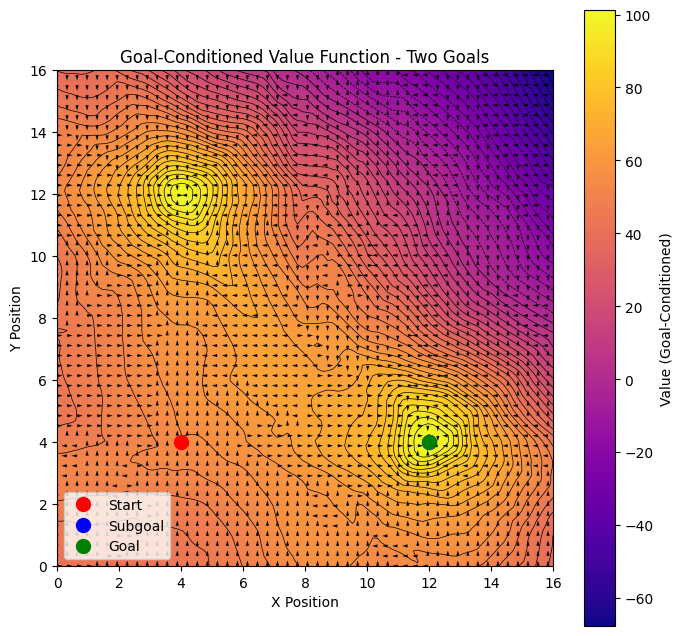

In [24]:
from achql.visualization.critic import make_test_plot_for_hdqn

plot1 = make_test_plot_for_hdqn(
        tmp_env,
        hdq_network,
        params,
        "Two Goals",
        seed=seed,
        save_and_close=False,
)

# Visualize Q Function 3

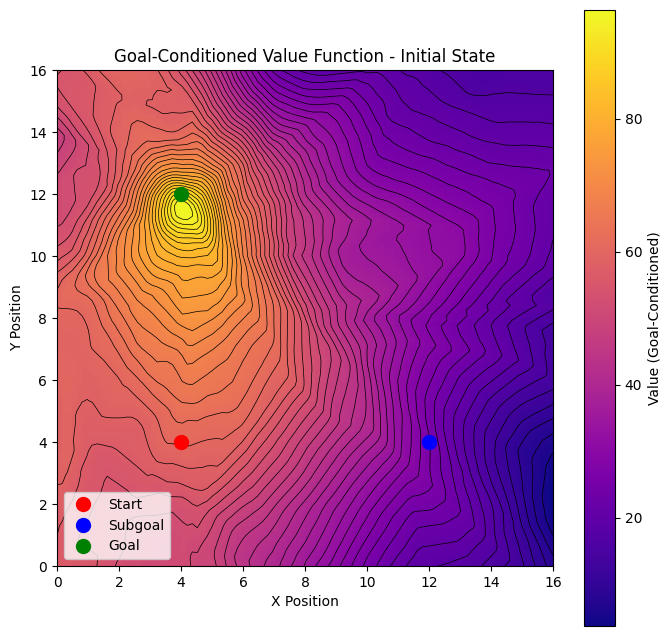

In [29]:
from achql.visualization.critic import make_plots_for_hdqn
from achql.brax.training.acme import running_statistics

seed=0

plot1 = make_plots_for_hdqn(
        aut_goal_mdp,
        hdq_aut_network,
        params,
        "Initial State",
        seed=seed,
        tmp_state_fn=lambda x: x.replace(obs=x.obs.at[-3:].set(jnp.array([2, 4, 12]))),
        save_and_close=False,
)